# Makemore Part 3

### Initializing the data

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [41]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [42]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Initial Loss is very high because our initialization is poor

In [13]:
# logits = torch.tensor([-3.0, 5.0, 1.0, 2.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([6.5274e-09, 1.0000e+00, 1.0853e-08, 3.2295e-10]), tensor(18.3388))

### Saturated tanh function
We are trying to figure out how some neurons could be dead when we we are using tanh

https://arxiv.org/abs/1502.01852

In [21]:
g = torch.Generator()
g.manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0 # Reducing the initial loss
parameters = [C, W1, b1, W2, b2]
lri = []
lossi = []
stepi = []

In [22]:
for p in parameters:
    p.requires_grad = True
for i in range(50000, 60000):
    
    # Mini batch 
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # Forward Pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.02
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.item())
    stepi.append(i)
    if i%500 == 0:
        print(f"iteration: {i}, loss: {loss.item()}")
    break

iteration: 50000, loss: 3.3003554344177246


(array([2135.,  163.,   81.,   60.,   58.,   40.,   39.,   36.,   40.,
          33.,   25.,   32.,   22.,   28.,   21.,   26.,   25.,   27.,
          28.,   26.,   19.,   23.,   20.,   24.,   19.,   12.,   20.,
          19.,   14.,   12.,   24.,   22.,   28.,   17.,   28.,   26.,
          25.,   20.,   19.,   31.,   23.,   38.,   29.,   47.,   57.,
          44.,   70.,   93.,  154., 2478.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

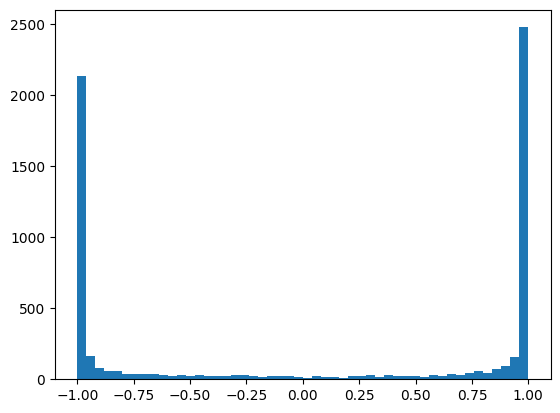

In [27]:
plt.hist(h.view(-1).tolist(), 50)
# The +1 and -1  in the histogram will just be dead during backpropogation as its derivative is 0 at both the values

In [31]:
g = torch.Generator()
g.manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * 0.1 # Reducing unactivated neurons in tanh
b1 = torch.randn(200, generator=g) * 0.01 # Reducing unactivated neurons in tanh
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0 # Reducing the initial loss
parameters = [C, W1, b1, W2, b2]
lri = []
lossi = []
stepi = []

In [32]:
for p in parameters:
    p.requires_grad = True
for i in range(50000, 60000):
    
    # Mini batch 
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # Forward Pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.02
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.item())
    stepi.append(i)
    if i%500 == 0:
        print(f"iteration: {i}, loss: {loss.item()}")
    break

iteration: 50000, loss: 3.324904203414917


(array([  6.,  24.,  26.,  37.,  59.,  62.,  72.,  91.,  99., 119., 150.,
        145., 157., 143., 143., 158., 175., 167., 153., 173., 171., 199.,
        202., 218., 170., 196., 188., 200., 185., 166., 198., 193., 157.,
        164., 137., 160., 186., 188., 170., 117., 119., 102., 118.,  78.,
         91.,  68.,  29.,  42.,  24.,   5.]),
 array([-0.96136862, -0.9225833 , -0.88379798, -0.84501266, -0.80622733,
        -0.76744201, -0.72865669, -0.68987137, -0.65108605, -0.61230072,
        -0.5735154 , -0.53473008, -0.49594476, -0.45715944, -0.41837412,
        -0.37958879, -0.34080347, -0.30201815, -0.26323283, -0.22444751,
        -0.18566219, -0.14687686, -0.10809154, -0.06930622, -0.0305209 ,
         0.00826442,  0.04704974,  0.08583507,  0.12462039,  0.16340571,
         0.20219103,  0.24097635,  0.27976167,  0.318547  ,  0.35733232,
         0.39611764,  0.43490296,  0.47368828,  0.5124736 ,  0.55125893,
         0.59004425,  0.62882957,  0.66761489,  0.70640021,  0.74518553,
 

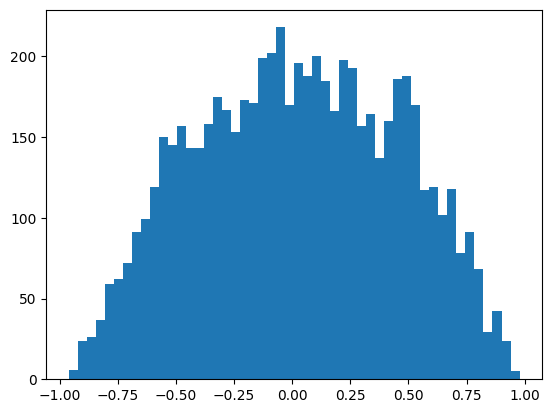

In [33]:
plt.hist(h.view(-1).tolist(), 50)

tensor(0.0024) tensor(0.9874)
tensor(-0.0109) tensor(3.0328)
tensor(0.0024) tensor(0.9874)
tensor(-0.0035) tensor(0.9591)


(array([4.77310352e-05, 9.54620703e-05, 4.77310352e-05, 1.90924141e-04,
        3.81848281e-04, 8.11427598e-04, 1.62285520e-03, 2.72066900e-03,
        4.17646558e-03, 7.44604148e-03, 1.14077174e-02, 1.73025002e-02,
        2.79465211e-02, 4.05475144e-02, 6.08093388e-02, 8.64886357e-02,
        1.20998174e-01, 1.71354416e-01, 2.30540900e-01, 2.92280994e-01,
        3.49462774e-01, 3.96788095e-01, 4.39316448e-01, 4.48098958e-01,
        4.22037813e-01, 3.83160885e-01, 3.23759611e-01, 2.60253469e-01,
        2.00016903e-01, 1.48658309e-01, 1.05175336e-01, 7.43172217e-02,
        5.07619559e-02, 3.38174384e-02, 2.38177865e-02, 1.34124209e-02,
        8.61545184e-03, 6.49142078e-03, 2.98318970e-03, 2.45814831e-03,
        9.30755185e-04, 7.87562080e-04, 2.62520693e-04, 1.19327588e-04,
        1.67058623e-04, 9.54620703e-05, 2.38655176e-05, 4.77310352e-05,
        2.38655176e-05, 2.38655176e-05]),
 array([-4.87960815, -4.67010086, -4.46059357, -4.25108627, -4.04157898,
        -3.83207169, 

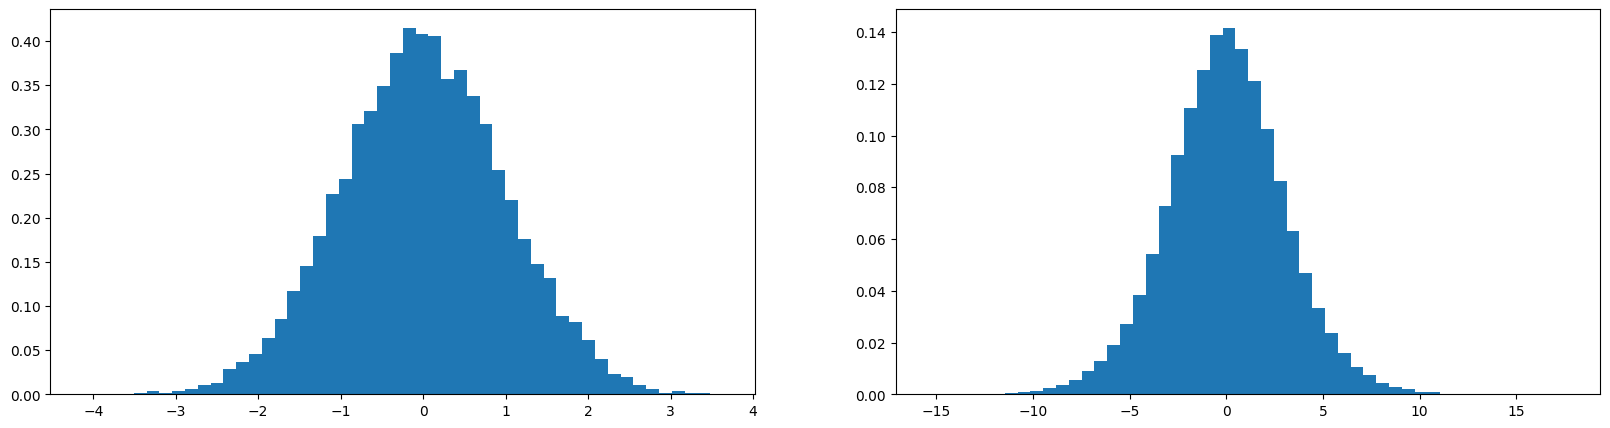

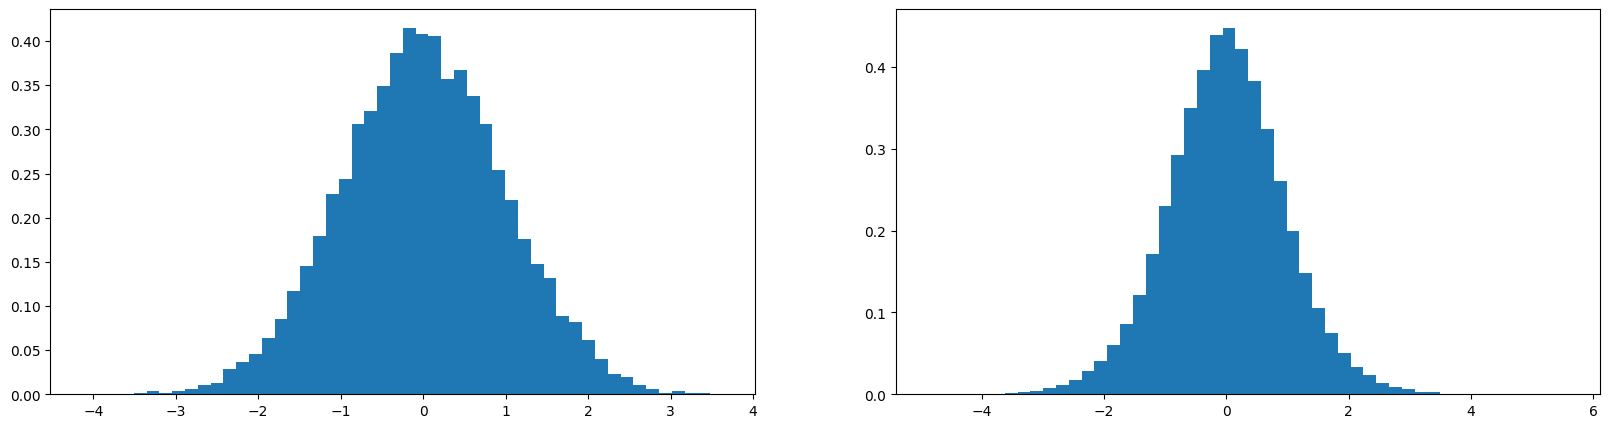

In [38]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

#-------------------We can see that the std is very high-------------------#

w /= 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

### Lecture 3: Activation, Gradients, BatchNorm

#### Initial Setup

In [57]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator()
g.manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # We do not need it as we are later subtracting it, hence grad of the bias is zero
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Reducing initialzation loss
b2 = torch.randn(vocab_size, generator=g) * 0 # Make sure b2 is 0 at initialization, this will help reduce the initial high loss

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [58]:
max_step = 2000
batch_size = 32
lossi = []

#### Batchnormalization
- We do not want our preactivation state way too small (tanh will be come zero) or very large (tanh will saturate)
- We have these hidden states which we want to be roughly gaussian
- Why not we take these states and normalize them? -> This was the insight
- When we normalize them to be gaussian, it won't have any bad impact

In [59]:
for i in range(max_step):
    
    # Mini batch 
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # Forward Pass
    emb = C[Xb] # 32, 3, 2
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # h-preactivation: hidden layer preactivation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    # We want our hidden layer to be gaussian only during initialization and not force it to be always gaussian and hence we add bngains and bnbias for the same

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # We are using momentum of 0.001 in batchnorm1d of torch.nn
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.02
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.item())
    stepi.append(i)
    if i%500 == 0:
        print(f"iteration: {i}, loss: {loss.item()}")

iteration: 0, loss: 3.2992329597473145
iteration: 500, loss: 2.648761749267578
iteration: 1000, loss: 2.522911310195923
iteration: 1500, loss: 2.2844769954681396


In [ ]:
with torch.no_grad():
  # passing the training set
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [56]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.6795897483825684
val 2.676372528076172


#### Torchifying our implementation
- Histogram of forward pass helps in understanding activation distribution.
  - It helps us understand that activation is not completely close to 0 or maybe very saturated
- Backward gradient graphs helps us understand the activation in backward pass
- Gradient to data ratio helps us understand how big is gradient in comparision to actual data. If this is very big, then the data will change very fast. This will reduce the chance of convergence
- Update to data ratio will tell how much the data is being changed in every iteration. A good value here could be 1e-3, both higher and lower values could have issues

In [61]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __self__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [63]:
n_embd = 10
n_hidden = 100
g = torch.Generator()
g.manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [64]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.2962
    100/  20000: 2.7981
    200/  20000: 2.5977
    300/  20000: 2.4347
    400/  20000: 2.4344
    500/  20000: 2.3127
    600/  20000: 2.5280
    700/  20000: 2.7441
    800/  20000: 2.4660
    900/  20000: 2.4275
   1000/  20000: 2.2701


- Why do we need tanh or other non-linear activation layer?
  - Miultiple linear layers is same as just having a single linear layer, A large WX + B

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

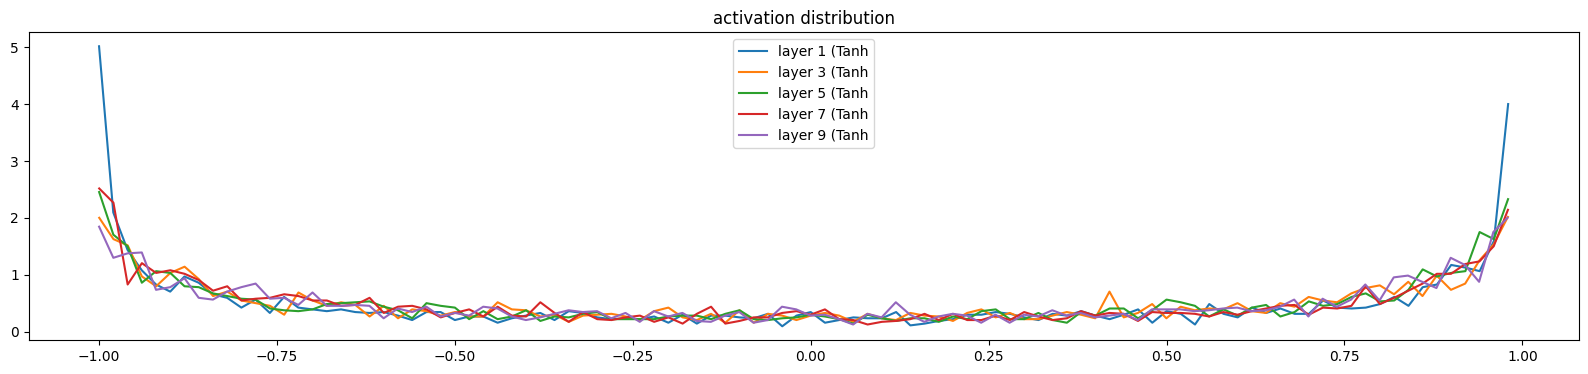

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715701e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

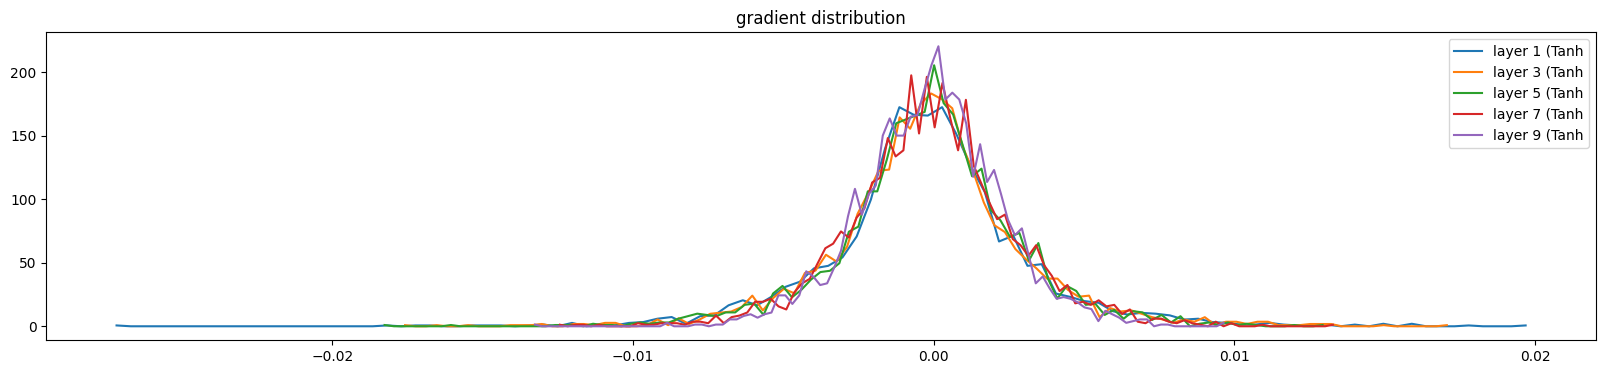

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086042e-03 | grad:data ratio 3.605769e-02
weight (100, 100) | mean -0.000077 | std 5.075622e-03 | grad:data ratio 3.015270e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


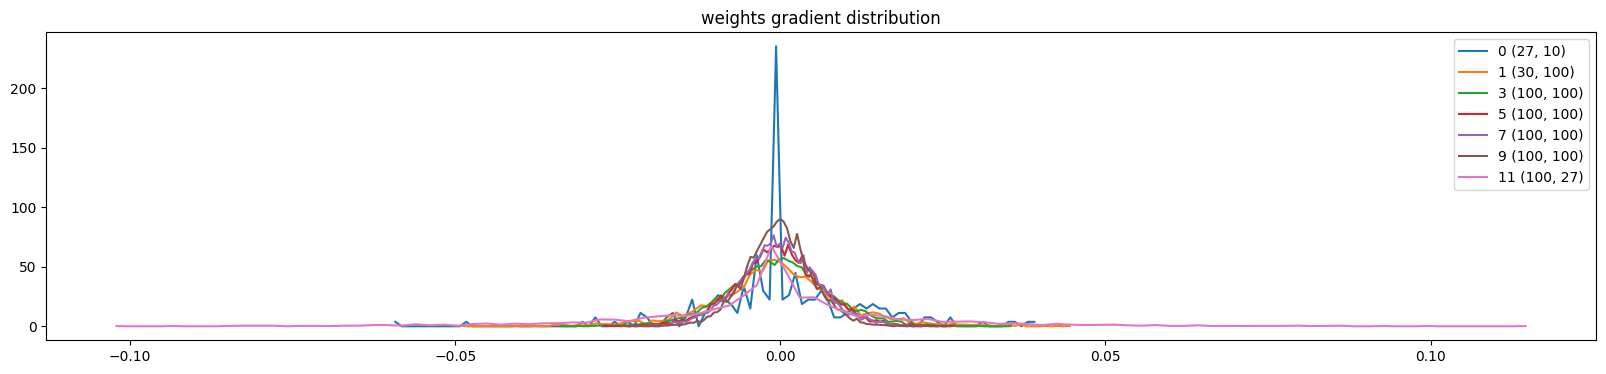

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


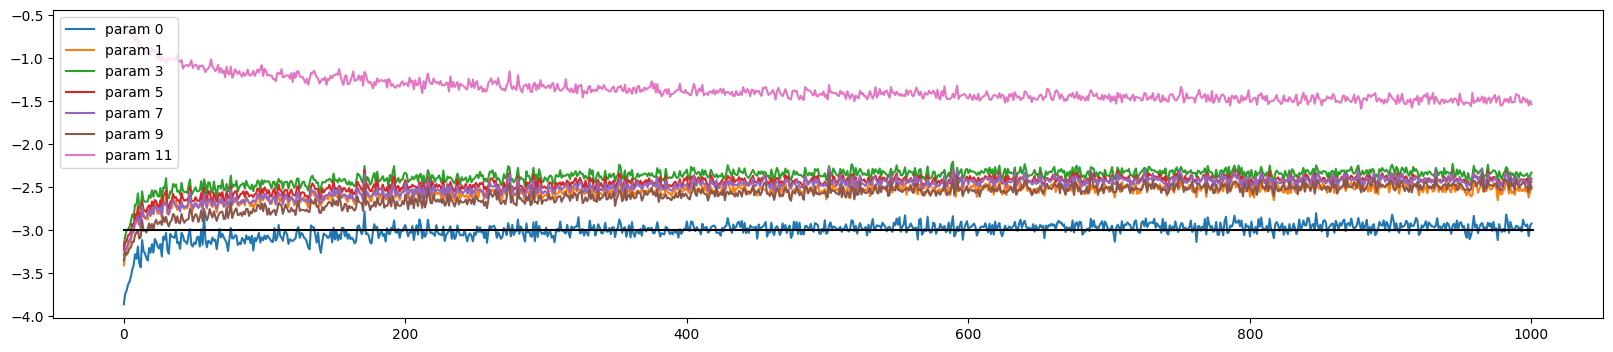

In [68]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [69]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.366689443588257
val 2.374152183532715


In [70]:
# sample from the model
g = torch.Generator()
g.manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


mriah.
myanniee.
madhahalarethrstengrlee.
ade.
korelii.
shi.
jen.
eden.
van.
aar.
kayzioh.
karin.
shdrergahianest.
jahr.
jelinnn.
puconuy.
kavder.
yarui.
eha.
kay.
